## sklearn

In [13]:
from sklearn.datasets import fetch_openml
import numpy as np
mnist = fetch_openml('mnist_784',version=1,data_home=r'./')  # 14M.

print(mnist.keys())

print(mnist['data'].shape, mnist['target'].shape)   # 'data', 'target'모두 정수 numpy array(dtype없음)
print(mnist['data'].dtype, mnist['target'].dtype)

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'DESCR', 'details', 'categories', 'url'])
(70000, 784) (70000,)
float64 object


In [11]:
mnist['data'].dtype, mnist['target'].dtype

(dtype('float64'), dtype('O'))

In [14]:
X = (mnist['data']/255).astype(np.float32)
Y = mnist['target'].astype(np.uint8)

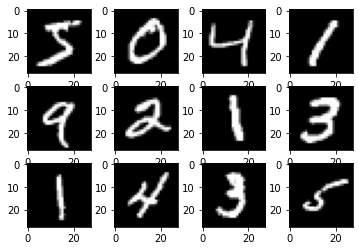

In [18]:
import matplotlib.pyplot as plt

for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(X[i].reshape(28,28),cmap='gray')

## Tensorflow

In [9]:
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()  # numpy array 
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)  # (60000, 28, 28) (60000,) (10000, 28, 28) (10000,)

dataset = tf.data.Dataset.from_tensor_slices((tf.cast(x_train[...,tf.newaxis]/255, tf.float32), tf.cast(y_train,tf.int32)))
dataset = dataset.shuffle(1000).batch(12)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


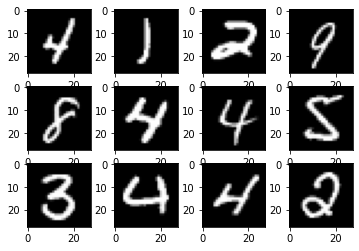

In [30]:
it = iter(dataset)
x,y = it.next()
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(x[i].numpy()[:,:,0],cmap='gray')

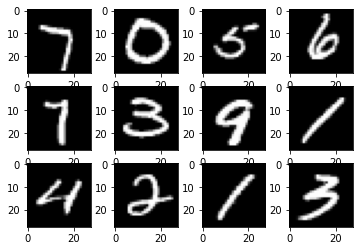

In [33]:
for x,y in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(x[i].numpy()[:,:,0],cmap='gray')

## pytorch

In [38]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

In [41]:
# 다운 받은 data는 PIL.Image.Image(np.array로 변환해 보면 shape(28,28) uint8)이다. transform을 통해 tensor로 변환해야 하다.
# (28,28)이기 때문에, reshape이 필요없다.
import torchvision.datasets as datasets
import torchvision.transforms as transforms
download_root = r'D:\hccho\CommonDataset\mnist'  #---> 아래에 MNIST- raw, processed 2개의 subdirectory가 생성된다. 

transform = transforms.Compose([transforms.ToTensor()]) # channel dim이 생성(1,28,28)

train_dataset = datasets.MNIST(download_root, transform=transform, train=True, download=True)   # transform을 넣어야 한다.
test_dataset = datasets.MNIST(download_root, transform=transform, train=False, download=True)

#train_dataset[0][0].show()  # PIL.Image.Image

print(len(train_dataset),len(test_dataset))   # 60000(1,28,28), 10000

train_loader = DataLoader(train_dataset,batch_size=12,shuffle=True)

60000 10000


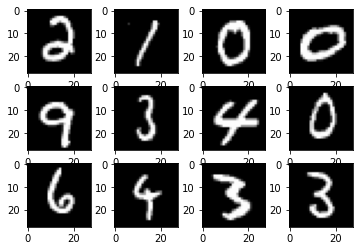

In [47]:
it = iter(train_loader)
x,y = it.next()
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(x[i,0].numpy(),cmap='gray')

In [44]:
x.shape

torch.Size([12, 1, 28, 28])